<a href="https://colab.research.google.com/github/asfuhr/Defects-in-MX2-Phases-DMX-/blob/master/Defects_in_MX2_(DMX)_STEM_Digital_Twins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Digital Twins and Deep Learning Segmentation of Defects in Monolayer MX2 Phases**

Addis S. Fuhr,1 Panchapakesan Ganesh,1 Rama K. Vasudevan,1 Bobby G. Sumpter,1 and Kevin M. Roccapriore1

Center for Nanophase Materials Sciences, Oak Ridge National Laboratory, Oak Ridge, TN,
United States

*Authors to whom correspondence should be addressed: Addis S. Fuhr, fuhras@ornl.gov, Bobby G. Sumpter, sumpterbg@ornl.gov

Importing packages and data

In [ ]:
!pip install ase
!pip install abtem==1.0.0b32

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.2/511.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 15.9 MB/s eta 0:00:00


Import required packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

from ase.io import read,write
from ase import Atoms,Atom

from abtem import *
from abtem import __version__
from abtem.structures import orthogonalize_cell
from abtem.noise import *
print('current version:', __version__)

current version: 1.0.0beta32


Example File: Defect-Free MoS2

In [ ]:
!wget -O MoS2_ORNL https://www.dropbox.com/scl/fi/y2qfttb6i52uattjb32kr/mos2-B_Defect-Free.vasp?rlkey=wsd4615si57wnqucfw00cg8tv&dl=0


--2023-10-13 22:49:10--  https://www.dropbox.com/scl/fi/y2qfttb6i52uattjb32kr/mos2-B_Defect-Free.vasp?rlkey=wsd4615si57wnqucfw00cg8tv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5b04342f86c45ea637caccceff.dl.dropboxusercontent.com/cd/0/inline/CFjiEZhdpVBR9-2klQKhjZ0IvHAGxFhcyvrfLp2rHRrIwGlRkIMmwmh92f25bSRn2GHK9wfpixiaViNYtQpiQNmuDWmC37aPi0P60az_x7RlopYrwW8tzHSfq2X-0d5JRVvhuEX5ROOBdwXBQsMRV9jR/file# [following]
--2023-10-13 22:49:10--  https://uc5b04342f86c45ea637caccceff.dl.dropboxusercontent.com/cd/0/inline/CFjiEZhdpVBR9-2klQKhjZ0IvHAGxFhcyvrfLp2rHRrIwGlRkIMmwmh92f25bSRn2GHK9wfpixiaViNYtQpiQNmuDWmC37aPi0P60az_x7RlopYrwW8tzHSfq2X-0d5JRVvhuEX5ROOBdwXBQsMRV9jR/file
Resolving uc5b04342f86c45ea637caccceff.dl.dropboxusercontent.com (uc5b04342f86c45ea637caccceff.dl.dropboxusercontent.com)... 162.125.2

In [ ]:
MoS2 = "MoS2_ORNL"

Code to simulate beam damage

In [ ]:
def remove_random_atom_and_neighbors(atoms, num_neighbors): #35 is the high end
    # Get the number of atoms in the cell
    num_atoms = len(atoms)

    # Select a random atom index
    random_index = random.randint(0, num_atoms - 1)

    # Find the indices of the five nearest neighbors of the selected atom
    positions = atoms.get_positions()
    distances = np.linalg.norm(positions - positions[random_index], axis=1)
    sorted_indices = np.argsort(distances)
    nearest_neighbor_indices = sorted_indices[1:num_neighbors + 1]

    # Remove the selected atom and its nearest neighbors from the simulation environment
    indices_to_remove = [random_index] + list(nearest_neighbor_indices)
    remaining_indices = [i for i in range(num_atoms) if i not in indices_to_remove]
    atoms = atoms[remaining_indices]

    return atoms

Code to simulate "messy dataset" structures

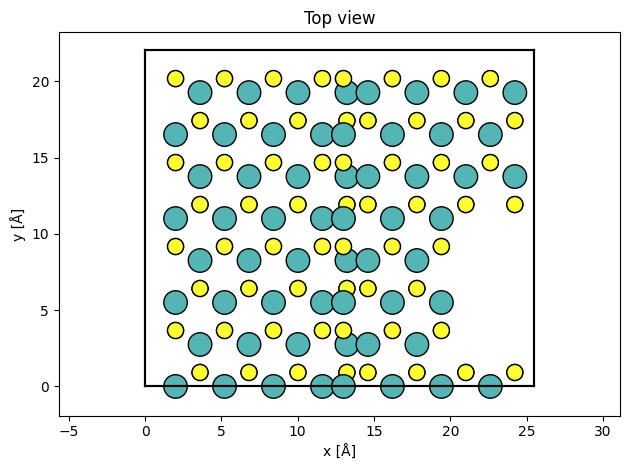

In [ ]:
operation_choice = [0, 1] # 0 rotation, 1 gb
damage_choice = [0, 1] # 0 no damage, 1 beam damage
solo_rot = [0, 30, 45, 90]
gb_rot = [0, 10, 45, 60]


#reference for non-messy operations
atoms = read(MoS2, format= 'vasp')
atoms.rotate(0, 'z', rotate_cell=True)
atoms_orth = orthogonalize_cell(atoms, max_repetitions=2)
ref_repetitions = (2, 1, 1)
atoms_orth *= ref_repetitions
atoms_orth.center(vacuum=2, axis=2)
atoms_cell = atoms_orth.cell

#operation & damage choice
operation = random.choice(operation_choice)
damage = random.choice(damage_choice)
#just rotation
if operation == 0:
  rotation = random.choice(solo_rot)
  atoms.rotate(rotation, 'z', rotate_cell=True)
  atoms_orth_new = orthogonalize_cell(atoms, max_repetitions=2)
  if rotation == 0 or rotation == 60:
    repetitions = (2, 1, 1)
    tiling = (2,1)
  elif rotation == 30 or rotation == 90:
    repetitions = (1, 2, 1)
    tiling = (1,2)
  elif rotation == 45:
    repetitions = (1, 1, 1)
    tiling = (1,1)
  atoms_orth_new *= repetitions
  atoms_orth_new.set_cell(atoms_cell)
  atoms_orth_new.center(vacuum=2, axis=2)
  positions = atoms_orth_new.get_positions()

#gb
if operation == 1:
  atom_bilayer1 = read(MoS2, format= 'vasp') #atoms.copy()
  atom_bilayer2 = read(MoS2, format= 'vasp') #atoms.copy()

  rotation = random.choice(gb_rot)
  atom_bilayer1.rotate(-rotation / 2, 'z', rotate_cell=True)
  atom_bilayer2.rotate(rotation / 2, 'z', rotate_cell=True)

  repetitions = (1, 1, 1)
  tiling = (1,1)
  if rotation == 0 or rotation == 10 or rotation == 60:
    bi_2_rep = 2

  elif rotation == 30 or rotation == 45:
    bi_2_rep = 1

  atom_bilayer1_orth = orthogonalize_cell(atom_bilayer1, max_repetitions=2)
  atom_bilayer2_orth = orthogonalize_cell(atom_bilayer2, max_repetitions=bi_2_rep)

  atom_bilayer3 = atom_bilayer1_orth * repetitions
  atom_bilayer4 = atom_bilayer2_orth * repetitions

  short_t = [0, 1, 2]
  long_t1 = [12, 13, 14, 15]
  long_t2 = [11, 12, 13, 14]
  long_t3 = [10, 11, 12, 13]

  if rotation == 0 or rotation == 10:
    tran_x = random.choice(long_t2)
    tran_y = random.choice(short_t)
    tran_axis = 0

  elif rotation == 30:
    tran_x = random.choice(short_t)
    tran_y = random.choice(long_t1)
    tran_axis = 1

  elif rotation == 45:
    tran_x = random.choice(short_t)
    tran_y = random.choice(long_t2)
    tran_axis = 1

  elif rotation == 60:
    tran_x = random.choice(short_t)
    tran_y = random.choice(long_t3)
    tran_axis = 1

  atom_bilayer3.translate((tran_x, tran_y, 3.5))
  atom_bilayer4.translate((0, 0, 0))

  atom_bilayer5 = atom_bilayer4 + atom_bilayer3

  atom_bilayer5.set_cell(atoms_cell)
  atom_bilayer5.center(vacuum=2, axis=tran_axis)
  positions = atom_bilayer5.get_positions()

#delete excess atoms

# Create a list to store the indices of atoms inside the cell
inside = []
for i, pos in enumerate(positions):
  # Check if the atom is inside the cell
  inside_cell = True
  for j in range(2):
    if pos[j] < 0 or pos[j] >= atoms_cell[j, j]:
      inside_cell = False
      break
        # If the atom is inside the cell, add its index to the list
  if inside_cell:
    inside.append(i)

inside_np = np.array(inside)

# Delete all atoms outside the cell
if operation == 0:
  atoms_orth_new = Atoms(np.array(atoms_orth_new.get_chemical_symbols())[inside_np],
                         positions=positions[inside_np],
                         cell=atoms_cell,
                         pbc=True)

elif operation == 1:
  atom_bilayer5 = Atoms(np.array(atom_bilayer5.get_chemical_symbols())[inside_np],
                        positions=positions[inside_np],
                        cell=atoms_cell,
                        pbc=True)

#account for beam damage operations
if damage == 0:
  bd = 0

elif damage == 1 and operation == 0:
  num_neighbors = random.randrange(5, 31, 1)
  bd = num_neighbors
  atoms_orth_new = remove_random_atom_and_neighbors(atoms_orth_new, num_neighbors)

elif damage == 1 and operation == 1:
  num_neighbors = random.randrange(5, 31, 1)
  bd = num_neighbors
  atom_bilayer5 = remove_random_atom_and_neighbors(atom_bilayer5, num_neighbors)


#plot

if operation == 0:
  final_structure = atoms_orth_new
  fig, ax = plt.subplots()
  show_atoms(final_structure, ax=ax, title='Top view')
  fig.tight_layout()

elif operation == 1:
  final_structure = atom_bilayer5
  fig, ax = plt.subplots()
  show_atoms(final_structure, ax=ax, title='Top view')
  fig.tight_layout()

Code to generate digital twins for messy dataset structures

Scan:   0%|          | 0/4012 [00:00<?, ?it/s]

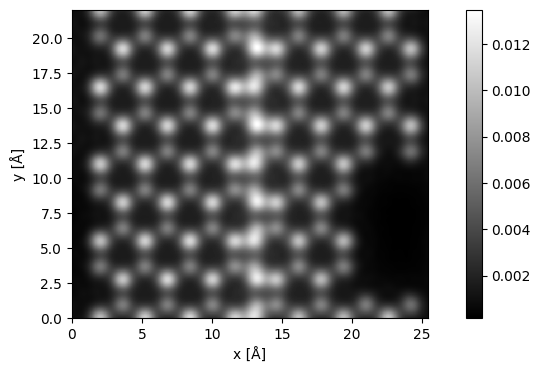

In [ ]:
probe = Probe(energy=80e3, semiangle_cutoff=25, defocus = 40, Cs=4e5, focal_spread = 40)
detector = FlexibleAnnularDetector()

atoms = final_structure

atoms.center(vacuum=2, axis=2)

potential = Potential(atoms,
                      gpts=256,
                      projection='finite',
                      slice_thickness=1,
                      parametrization='kirkland')

potential = potential.build()
probe.grid.match(potential)



end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)


haadf_measurement = measurement.integrate(50, 200)
interp_haadf_measurement = haadf_measurement.tile((tiling)).interpolate(.04)
fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
interp_haadf_measurement.show(ax=ax1, cbar=True);

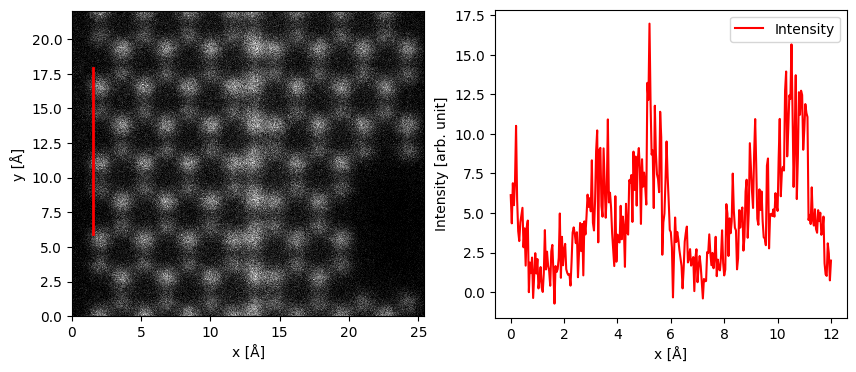

In [ ]:
#adding Poisson noise for beam dosage
noisy_measurement = poisson_noise(interp_haadf_measurement, 1e6)
# consider near exactly matching profile
start = (1.5, 6.9)
end = (1.5, 16.9)

line_intensity = noisy_measurement.interpolate_line(start, end, margin=1.)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

noisy_measurement.show(ax=ax1)

line_intensity.add_to_mpl_plot(ax1, color='r')

line_intensity.show(ax=ax2, color='r', label='Intensity')

ax2.set_ylabel('Intensity [arb. unit]')

ax2.legend();

auxiliary dataset structures: Including frozen phonon

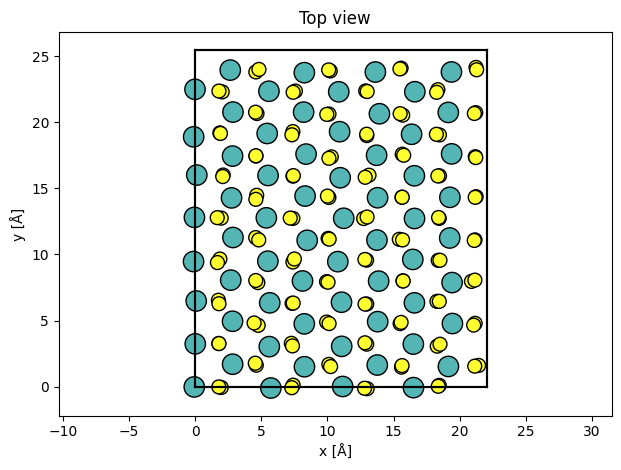

In [ ]:
operation_choice = [0, 1] # 0 rotation, 1 gb
damage_choice = [0, 1] # 0 no damage, 1 beam damage
solo_rot = [0, 30, 45, 90]
gb_rot = [0, 10, 45, 60]


#reference for no messy operations
atoms = read(MoS2, format= 'vasp')
atoms.rotate(0, 'z', rotate_cell=True)
atoms_orth = orthogonalize_cell(atoms, max_repetitions=2)
ref_repetitions = (2, 1, 1)
atoms_orth *= ref_repetitions
atoms_orth.center(vacuum=2, axis=2)
atoms_cell = atoms_orth.cell

#operation & damage choice
operation = random.choice(operation_choice)
damage = random.choice(damage_choice)
#just rotation
if operation == 0:
  rotation = random.choice(solo_rot)
  atoms.rotate(rotation, 'z', rotate_cell=True)
  atoms_orth_new = orthogonalize_cell(atoms, max_repetitions=2)
  if rotation == 0 or rotation == 60:
    repetitions = (2, 1, 1)
    tiling = (2,1)
  elif rotation == 30 or rotation == 90:
    repetitions = (1, 2, 1)
    tiling = (1,2)
  elif rotation == 45:
    repetitions = (1, 1, 1)
    tiling = (1,1)
  atoms_orth_new *= repetitions
  if rotation == 45:
    atoms_orth_new.set_cell(atoms_cell)
  else:
    pass
  atoms_orth_new.center(vacuum=2, axis=2)
  positions = atoms_orth_new.get_positions()

#gb
if operation == 1:
  atom_bilayer1 = read(MoS2, format= 'vasp') #atoms.copy()
  atom_bilayer2 = read(MoS2, format= 'vasp') #atoms.copy()

  rotation = random.choice(gb_rot)
  atom_bilayer1.rotate(-rotation / 2, 'z', rotate_cell=True)
  atom_bilayer2.rotate(rotation / 2, 'z', rotate_cell=True)

  repetitions = (1, 1, 1)
  tiling = (1,1)
  if rotation == 0 or rotation == 10 or rotation == 60:
    bi_2_rep = 2

  elif rotation == 30 or rotation == 45:
    bi_2_rep = 1

  atom_bilayer1_orth = orthogonalize_cell(atom_bilayer1, max_repetitions=2)
  atom_bilayer2_orth = orthogonalize_cell(atom_bilayer2, max_repetitions=bi_2_rep)

  atom_bilayer3 = atom_bilayer1_orth * repetitions
  atom_bilayer4 = atom_bilayer2_orth * repetitions

  short_t = [0, 1, 2]
  long_t1 = [12, 13, 14, 15]
  long_t2 = [11, 12, 13, 14]
  long_t3 = [10, 11, 12, 13]

  if rotation == 0 or rotation == 10:
    tran_x = random.choice(long_t2)
    tran_y = random.choice(short_t)
    tran_axis = 0

  elif rotation == 30:
    tran_x = random.choice(short_t)
    tran_y = random.choice(long_t1)
    tran_axis = 1

  elif rotation == 45:
    tran_x = random.choice(short_t)
    tran_y = random.choice(long_t2)
    tran_axis = 1

  elif rotation == 60:
    tran_x = random.choice(short_t)
    tran_y = random.choice(long_t3)
    tran_axis = 1

  atom_bilayer3.translate((tran_x, tran_y, 3.5))
  atom_bilayer4.translate((0, 0, 0))

  atom_bilayer5 = atom_bilayer4 + atom_bilayer3

  atom_bilayer5.set_cell(atoms_cell)
  atom_bilayer5.center(vacuum=2, axis=tran_axis)
  positions = atom_bilayer5.get_positions()

#delete excess atoms

# Create a list to store the indices of atoms inside the cell
inside = []
for i, pos in enumerate(positions):
  # Check if the atom is inside the cell
  inside_cell = True
  for j in range(2):
    if pos[j] < 0 or pos[j] >= atoms_cell[j, j]:
      inside_cell = False
      break
        # If the atom is inside the cell, add its index to the list
  if inside_cell:
    inside.append(i)

inside_np = np.array(inside)

# Delete all atoms outside the cell
if operation == 0 and rotation == 45:
  atoms_orth_new = Atoms(np.array(atoms_orth_new.get_chemical_symbols())[inside_np],
                         positions=positions[inside_np],
                         cell=atoms_cell,
                         pbc=True)

elif operation == 1:
  atom_bilayer5 = Atoms(np.array(atom_bilayer5.get_chemical_symbols())[inside_np],
                        positions=positions[inside_np],
                        cell=atoms_cell,
                        pbc=True)

else:
  pass

#account for beam damage operations
if damage == 0:
  bd = 0

elif damage == 1 and operation == 0:
  num_neighbors = random.randrange(5, 31, 1)
  bd = num_neighbors
  atoms_orth_new = remove_random_atom_and_neighbors(atoms_orth_new, num_neighbors)

elif damage == 1 and operation == 1:
  num_neighbors = random.randrange(5, 31, 1)
  bd = num_neighbors
  atom_bilayer5 = remove_random_atom_and_neighbors(atom_bilayer5, num_neighbors)


#plot and incorporate frozen phonon
if operation == 0:
  final_structure = FrozenPhonons(atoms_orth_new, 10, 0.1)
  fig, ax = plt.subplots()
  show_atoms(next(iter(final_structure)), ax=ax, title='Top view')
  fig.tight_layout()

elif operation == 1:
  final_structure = FrozenPhonons(atom_bilayer5, 10, 0.1)
  fig, ax = plt.subplots()
  show_atoms(next(iter(final_structure)), ax=ax, title='Top view')
  fig.tight_layout()

Scan:   0%|          | 0/2100 [00:00<?, ?it/s]

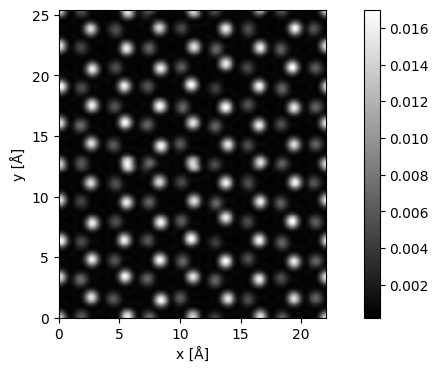

In [ ]:
probe = Probe(energy=60e3, semiangle_cutoff=30, Cs=0, defocus=0)
detector = FlexibleAnnularDetector()

atoms = final_structure

potential = Potential(atoms,
                      gpts=256,
                      projection='finite',
                      slice_thickness=1,
                      parametrization='kirkland')

potential = potential.build()
probe.grid.match(potential)



end = (potential.extent[0] / repetitions[0], potential.extent[1] / repetitions[1])

gridscan = GridScan(start=[0, 0], end=end, sampling=probe.ctf.nyquist_sampling * .9)

measurement = probe.scan(gridscan, detector, potential)


haadf_measurement = measurement.integrate(80, 200)
interp_haadf_measurement = haadf_measurement.tile((tiling)).interpolate(.04)
fig, (ax1) = plt.subplots(1, 1, figsize=(10,4))
interp_haadf_measurement.show(ax=ax1, cbar=True);

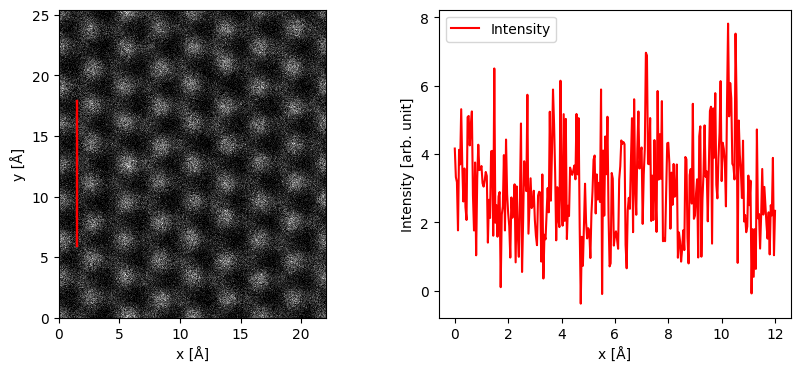

In [ ]:
#adding Poisson noise for beam dosage and Gaussian filter for measurement artifacts
noisy_measurement = poisson_noise(interp_haadf_measurement.gaussian_filter(0.5), 1e6)

start = (1.5, 6.9)
end = (1.5, 16.9)

line_intensity = noisy_measurement.interpolate_line(start, end, margin=1.)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

noisy_measurement.show(ax=ax1)

line_intensity.add_to_mpl_plot(ax1, color='r')

line_intensity.show(ax=ax2, color='r', label='Intensity')

ax2.set_ylabel('Intensity [arb. unit]')

ax2.legend();